In [2]:
%cd ..

/Users/brewer/Code/UU/CS6966/sanity_checks_saliency_vit


# ViT Cascading Randomization

In [39]:
from transformers import TFViTForImageClassification
from transformers import ViTConfig, ViTFeatureExtractor

In [4]:
from __future__ import absolute_import, division, print_function

%matplotlib inline

import operator
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

import tensorflow as tf
import seaborn as sns
import saliency.core as saliency
import pickle
import PIL
import json

# urllib python2 v. python3 hack.
if sys.version_info[0] == 3:
    from urllib.request import urlopen
else:
    from urllib import urlopen

import keras 
from matplotlib import gridspec
import seaborn as sns

from scipy.stats import spearmanr as spr
from scipy.stats import pearsonr
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from skimage import feature

import tf_slim as slim

# some plotting defaults
%matplotlib inline
sns.set_style('whitegrid', {'axes.grid': False})
SSIZE=10
MSIZE=12
BSIZE=14
plt.rc('font', size=SSIZE)
plt.rc('axes', titlesize=MSIZE)
plt.rc('axes', labelsize=MSIZE)
plt.rc('xtick', labelsize=MSIZE)
plt.rc('ytick', labelsize=MSIZE)
plt.rc('legend', fontsize=MSIZE)
plt.rc('figure', titlesize=MSIZE)
plt.rcParams['font.family'] = "sans-serif"

In [5]:
def abs_grayscale_norm(img):
    """Returns absolute value normalized image 2D."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        img = np.absolute(img)
        img = img/float(img.max())
    else:
        img = saliency.VisualizeImageGrayscale(img)
    return img

def diverging_norm(img):
    """Returns image with positive and negative values."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        imgmax = np.absolute(img).max()
        img = img/float(imgmax)
    else:
        img = saliency.VisualizeImageDiverging(img)
    return img

def plot_single_img(img,
                    ax=False,
                    norm=diverging_norm,
                    show_axis=False,
                    grayscale=False,
                    cmap='gray',
                    title='',
                    fig_size=(4,4)):
    plt.figure(figsize=fig_size)
    if norm:
        img = norm(img)
    if not show_axis:
        plt.axis('off')
    plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)

def LoadImage(file_path, resize=True, sztple=(224, 224)):
    img = PIL.Image.open(file_path).convert('RGB')
    if resize:
        img = img.resize(sztple, PIL.Image.ANTIALIAS)
    img = np.asarray(img)
    return img / 127.5 - 1.0

def ShowImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    im = ((im + 1) * 127.5).astype(np.uint8)
    plt.imshow(im)
    plt.title(title)
    
def normalize_image(x):
    x = np.array(x).astype(np.float32)
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / (x_max - x_min)
    return x_norm

In [6]:
# Boilerplate methods.
def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')

    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

In [41]:
def get_batch(images):
    return [np.array(im).transpose((2, 0, 1)) for im in images]

def get_images(batch):
    return np.array(batch).transpose((0, 2, 3, 1))

def preprocess(batch):
    return feature_extractor(batch, return_tensors='tf')['pixel_values']

def predict(inputs):
    return model(inputs).logits

def get_label(logits):
    prediction = get_prediction(logits)
    return get_label_from_id(prediction)

def get_prediction(logits):
    return int(tf.math.argmax(logits, axis=-1))

def get_label_from_id(prediction):
    return model.config.id2label[prediction]

In [46]:
model_name = 'google/vit-base-patch16-224'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

# Pre-trained model.
# model = TFViTForImageClassification.from_pretrained(model_name)

# Randomized model!
config = ViTConfig.from_pretrained(model_name)
model = TFViTForImageClassification(config)

In [65]:
model.config.id2label[5]

'electric ray, crampfish, numbfish, torpedo'

In [59]:
model.config.id2label[126]

'isopod'

In [60]:
model.config.id2label[331]

'hare'

993 tf.Tensor(1.3414799, shape=(), dtype=float32) gyromitra
513 tf.Tensor(1.3352314, shape=(), dtype=float32) cornet, horn, trumpet, trump
238 tf.Tensor(1.3215586, shape=(), dtype=float32) Greater Swiss Mountain dog
466 tf.Tensor(1.2333901, shape=(), dtype=float32) bullet train, bullet
625 tf.Tensor(1.2255018, shape=(), dtype=float32) lifeboat
56 tf.Tensor(1.2110167, shape=(), dtype=float32) king snake, kingsnake
949 tf.Tensor(1.2073843, shape=(), dtype=float32) strawberry
856 tf.Tensor(1.1977148, shape=(), dtype=float32) thresher, thrasher, threshing machine
716 tf.Tensor(1.163917, shape=(), dtype=float32) picket fence, paling
430 tf.Tensor(1.15837, shape=(), dtype=float32) basketball
78 tf.Tensor(1.1298889, shape=(), dtype=float32) tick
829 tf.Tensor(1.1235482, shape=(), dtype=float32) streetcar, tram, tramcar, trolley, trolley car
910 tf.Tensor(1.0981697, shape=(), dtype=float32) wooden spoon
552 tf.Tensor(1.0799375, shape=(), dtype=float32) feather boa, boa
527 tf.Tensor(1.065175, 

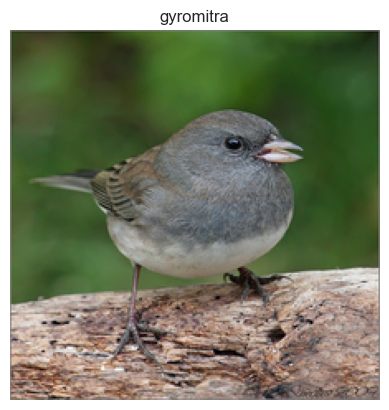

In [47]:
# Get bird image
# birdimgpath = './data/demo_images/ILSVRC2012_val_00015410.JPEG'  # junco
birdimgpath = './data/demo_images/ILSVRC2012_val_00021206.JPEG'  # 

images = []
images.append(LoadImage(birdimgpath, resize=True))
demo_batch = get_batch(images)
demo_inputs = preprocess(demo_batch)

demo_logits = predict(demo_inputs)
for i, logit in sorted(enumerate(demo_logits[0]), key=operator.itemgetter(1), reverse=True):
    label = get_label_from_id(i)
    print(i, logit, label)
    if 'junco' in label.lower():
        break
label = get_label(demo_logits[0])
ShowImage(images[0], title=label)

In [48]:
model.layers

In [49]:
model.layers[0].encoder

In [50]:
len(model.layers[0].encoder.layer)

12

In [51]:
a = model(demo_inputs)
type(a)

transformers.modeling_tf_outputs.TFSequenceClassifierOutput

## Make a saliency map

In [52]:
# see https://github.com/pair-code/saliency/blob/master/Examples_core.ipynb
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx = call_model_args[class_idx_str]
    batch = get_batch(images)
    inputs = preprocess([x for x in batch])
    output = dict()
    for key in expected_keys:
        if key == saliency.base.INPUT_OUTPUT_GRADIENTS:
            with tf.GradientTape() as tape:
                tape.watch(inputs)
                logits = model(inputs).logits[:, target_class_idx]
                gradients = np.array(tape.gradient(logits, inputs))
                gradient_images = get_images(gradients)
                output[key] = gradient_images
        else:
            raise KeyError('Key not handled: {}'.format(key))
    return output

In [53]:
def get_saliency_map(image, target_class_idx, mask_fn, **mask_kw):
    call_model_args = {class_idx_str: target_class_idx}
    mask = mask_fn(image, call_model_function, call_model_args, **mask_kw)  # 3d
    if len(mask.shape) == 2:
        return mask
    return saliency.VisualizeImageGrayscale(mask)  # 2d

image = images[0]
target_class_idx = model.config.label2id['junco, snowbird']  # 13
# target_class_idx_pred = get_prediction(demo_logits[0])  # 17, 'jay'

In [54]:
def plot_map(map_, method, cmap=None):
    # fig, axes = plt.subplots(1, c, figsize=(6*c, 6*r))
    plt.figure(figsize=(12, 12))
    plt.imshow(map_, cmap=cmap)
    plt.title(method)
    plt.axis('off')

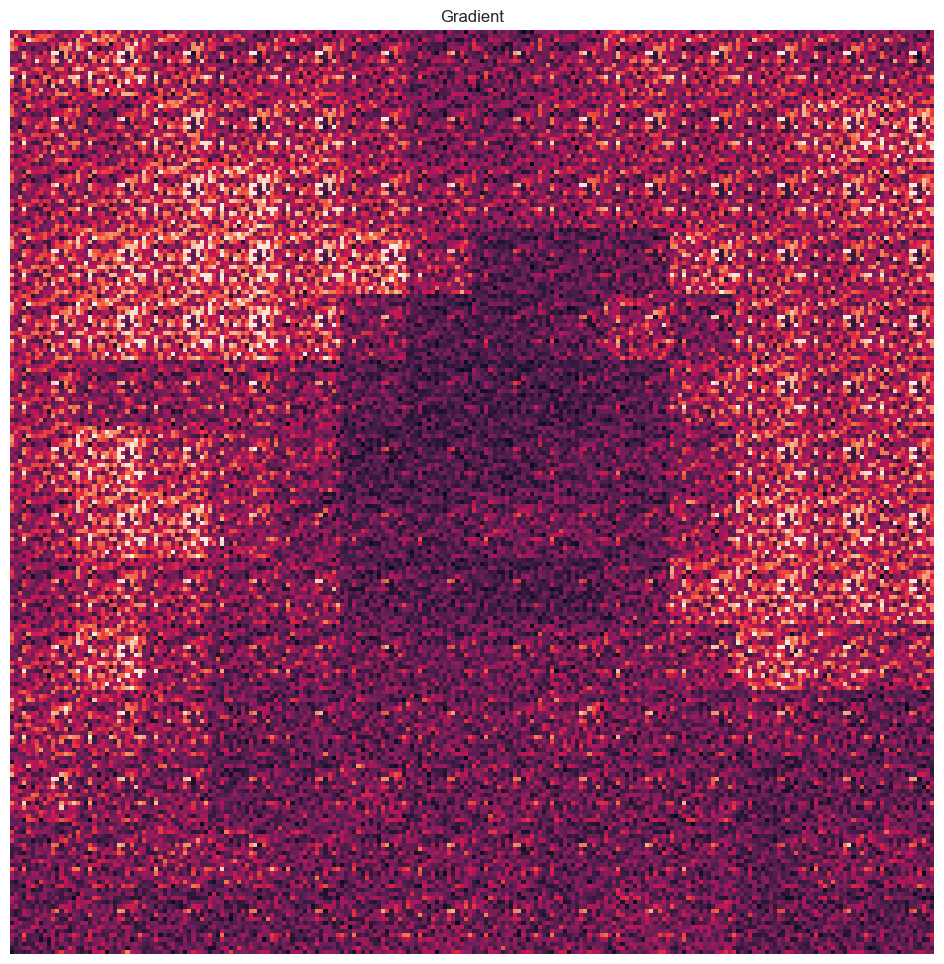

In [55]:
gradient = saliency.GradientSaliency()
map_vanilla = get_saliency_map(image, target_class_idx, gradient.GetMask)
plot_map(map_vanilla, 'Gradient')
del map_vanilla

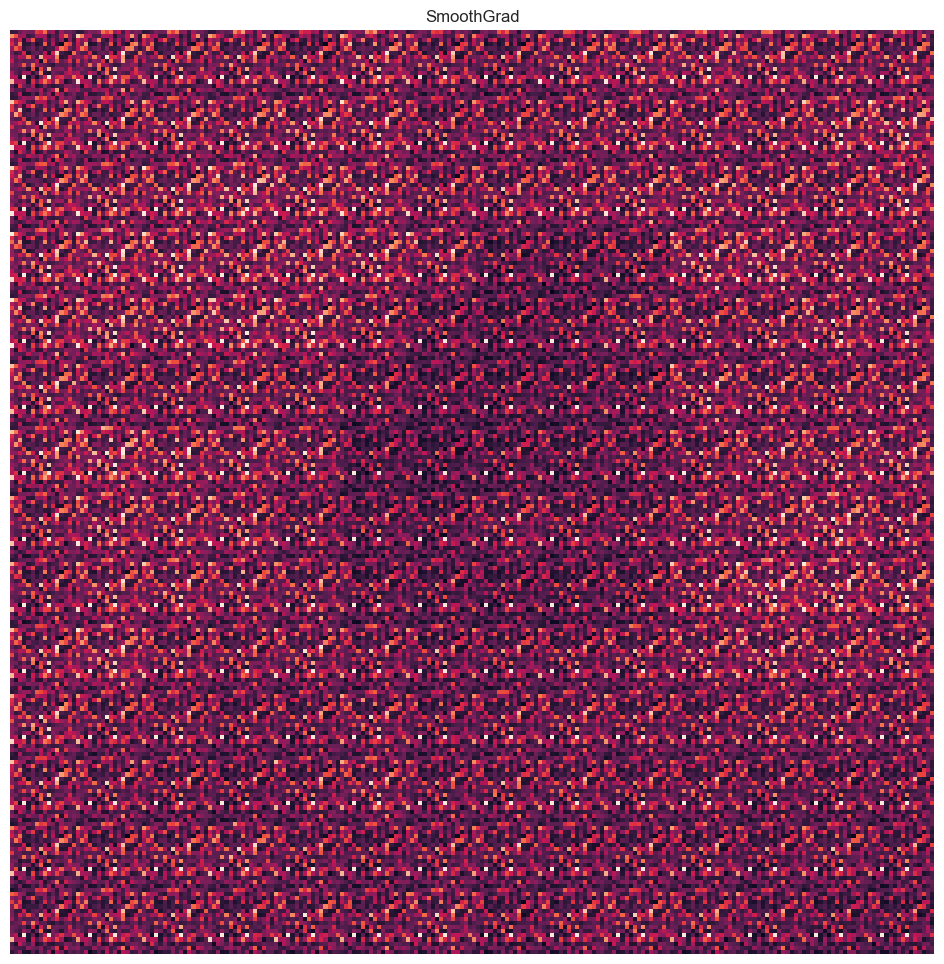

In [56]:
map_smooth = get_saliency_map(image, target_class_idx, gradient.GetSmoothedMask)
plot_map(map_smooth, 'SmoothGrad')
del map_smooth
del gradient

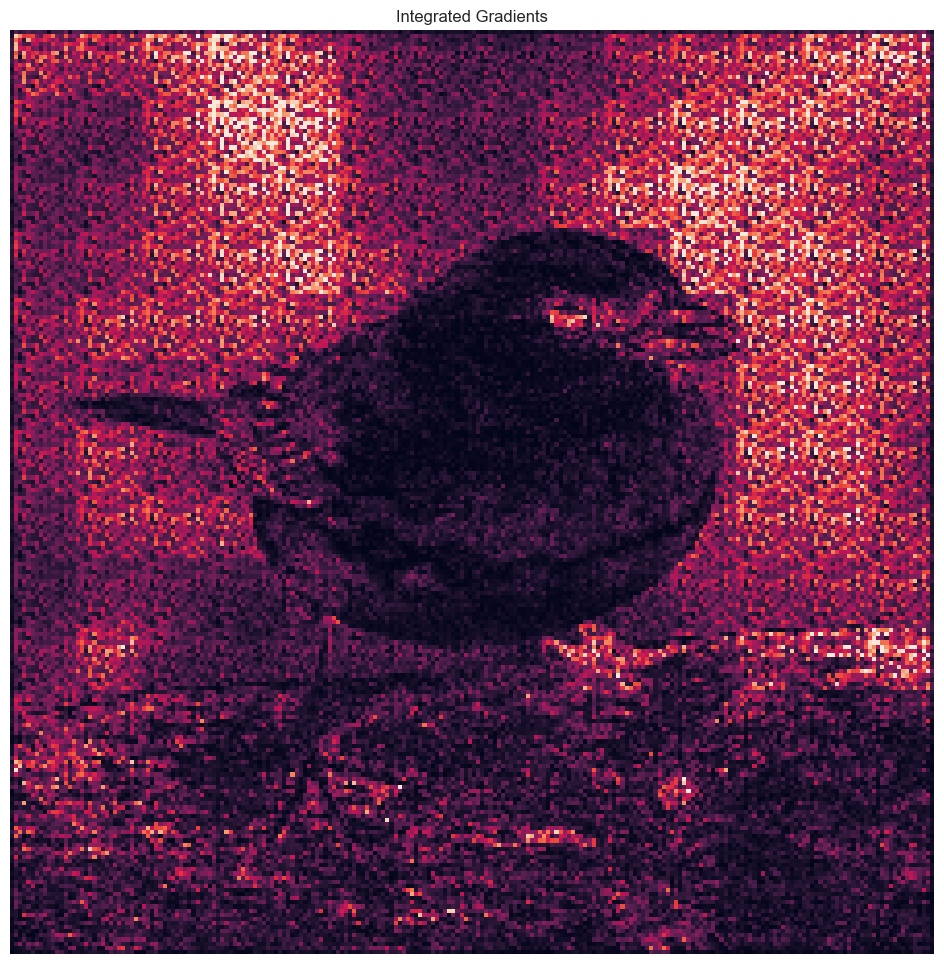

In [57]:
ig = saliency.IntegratedGradients()
x_baseline = np.zeros(images[0].shape)
map_integrated_gradients = get_saliency_map(image, target_class_idx, ig.GetMask,
                                            x_steps=25, x_baseline=x_baseline, batch_size=20)
plot_map(map_integrated_gradients, 'Integrated Gradients')
del map_integrated_gradients

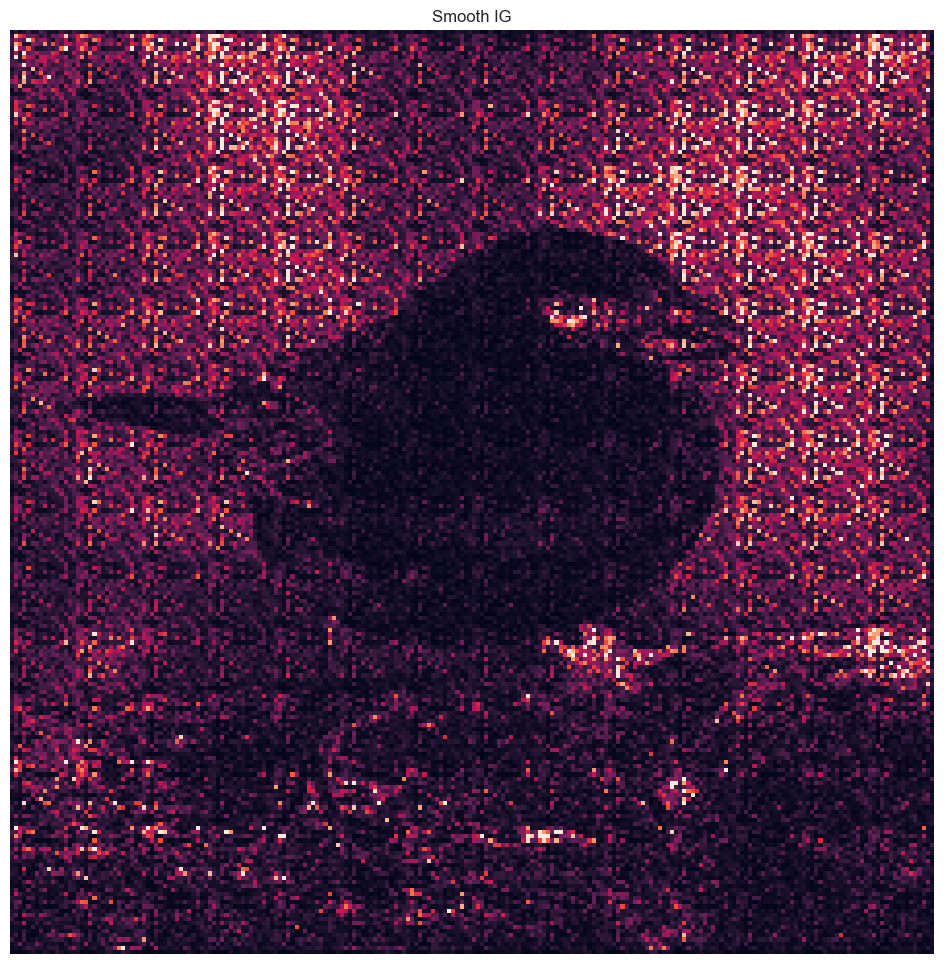

In [58]:
map_smoothed_integrated_gradients = get_saliency_map(image, target_class_idx, ig.GetSmoothedMask,
                                                     x_steps=25, x_baseline=x_baseline, batch_size=20)
plot_map(map_smoothed_integrated_gradients, 'Smooth IG')
del map_smoothed_integrated_gradients
del x_baseline
del ig

In [ ]:
xrai = saliency.XRAI()
xrai_params = saliency.XRAIParameters()
xrai_params.algorithm = 'fast'
attr_xrai = get_saliency_map(image, target_class_idx, xrai.GetMask, extra_parameters=xrai_params, batch_size=20)
plot_map(attr_xrai, 'XRAI', cmap='inferno')
del attr_xrai
del xrai_params
del xrai